# Bird Classification using transfer learning

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torch.optim import lr_scheduler
import os
from PIL import Image
import numpy as np
import time
import copy

In [6]:
DATASET_DIR = '/media/grzetan/445C33B25C339E1C/datasets/birds'

class BirdDataset(Dataset):
    def __init__(self, root_dir, random_state=42, transform=None):
        np.random.seed(random_state)
        self.root = root_dir
        self.classes = os.listdir(self.root)
        self.n_classes = len(self.classes)
        self.paths = []
        self.labels = []
        for cls in self.classes:
            for p in os.listdir(os.path.join(self.root, cls)):
                self.paths.append(os.path.join(self.root, cls, p))
                self.labels.append(self.classes.index(cls))
        self.paths = np.array(self.paths)
        self.labels = np.array(self.labels)
        idx = np.random.permutation(len(self.paths))
        self.paths = self.paths[idx]
        self.labels = self.labels[idx]
        self.transform = transform
        
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = np.asarray(Image.open(self.paths[idx]))
        
        sample = (img, label)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def __len__(self):
        return len(self.labels)

## Transforms

In [7]:
class ToTensor(object):
    def __call__(self, sample):
        img, label = sample
        img = img / 255
        img = img.transpose((2,0,1))
        return (torch.from_numpy(img).to(torch.float), torch.tensor(label).to(torch.int64))
    
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    
    def __call__(self, sample):
        img, label = sample
        img = (img - self.mean[:,None,None]) / self.std[:,None,None]
        return img, label        

In [8]:
normalize = Normalize(mean=[0.4451, 0.4262, 0.3959], std=[0.2411, 0.2403, 0.2466])

train_set = BirdDataset(os.path.join(DATASET_DIR, 'train'), 
                      transform=transforms.Compose([ToTensor(), normalize]))
test_set = BirdDataset(os.path.join(DATASET_DIR, 'test'), 
                      transform=transforms.Compose([ToTensor(), normalize]))
val_set = BirdDataset(os.path.join(DATASET_DIR, 'valid'), 
                      transform=transforms.Compose([ToTensor(), normalize]))

train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)
val_loader = DataLoader(val_set, batch_size=64)

In [9]:
resnet = resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import matplotlib.pyplot as plt

def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    print(len(layers), len(ave_grads))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

def train_model(model, criterion, optimizer, scheduler, epochs=25):
    start = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs-1}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_acc = 0.0
            
            dataloader = train_loader if phase == 'train' else val_loader
            
            for i, (inputs, labels) in enumerate(dataloader):
                print(f'\r{i / len(dataloader)}%', end='')
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        plot_grad_flow(model.named_parameters())
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(preds == labels)
        
            if phase == 'train':
                scheduler.step()
                
            # Stats
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print(f'{phase} - loss: {epoch_loss}, acc - {epoch_acc}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())

    t = time.time() - start
    print(f'Training completed in {t}, best accuracy: {best_acc}')
    model.load_state_dict(best_weights)
    return model

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
in_features = resnet.fc.in_features

# Freeze all the layers except last one 
for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = torch.nn.Linear(in_features, train_set.n_classes)
resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



Epoch 0/9
0.0%1 1


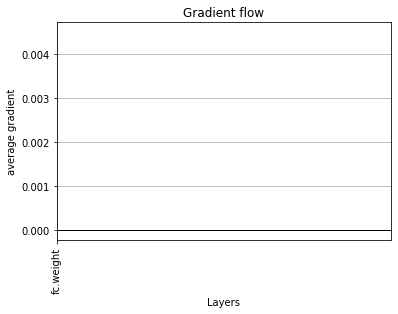

0.0013513513513513514%1 1


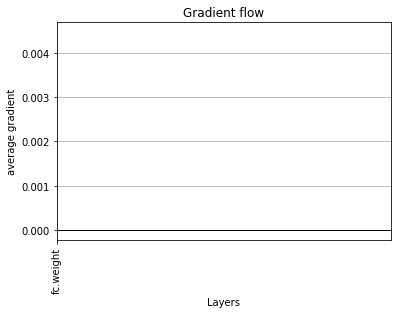

0.002702702702702703%1 1


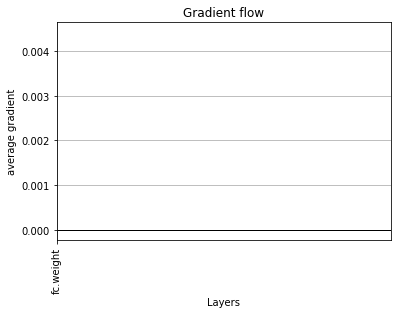

0.004054054054054054%1 1


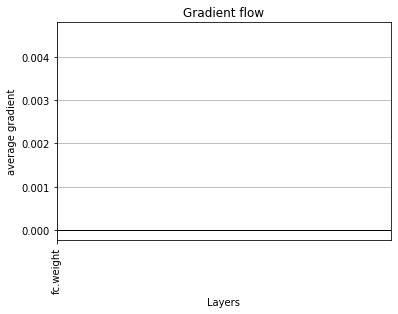

0.005405405405405406%1 1


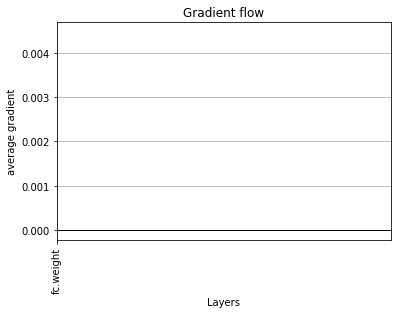

0.006756756756756757%1 1


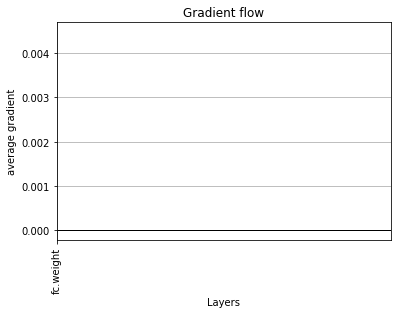

0.008108108108108109%1 1


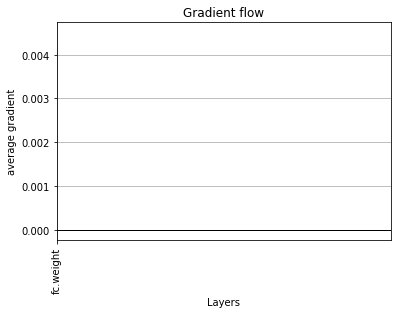

0.00945945945945946%1 1


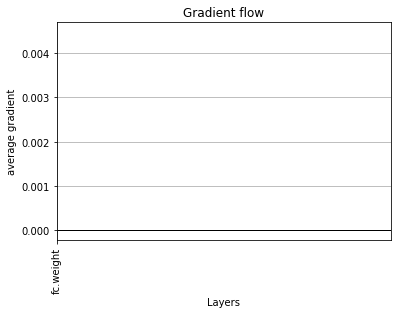

0.010810810810810811%1 1


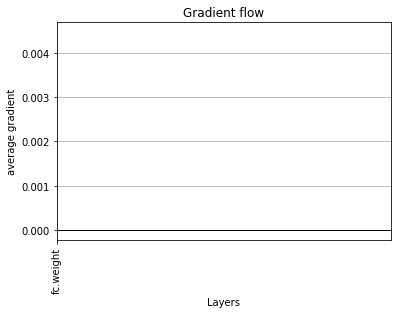

0.012162162162162163%1 1


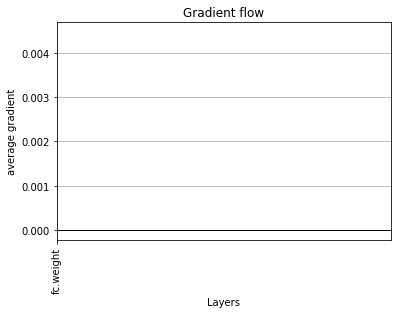

0.013513513513513514%1 1


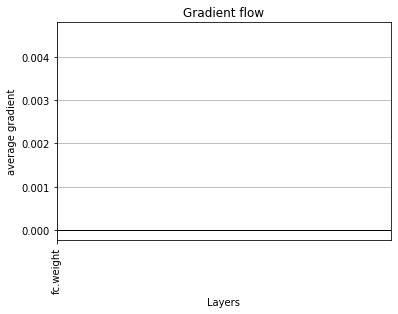

0.014864864864864866%1 1


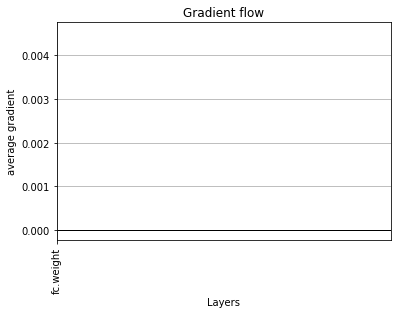

0.016216216216216217%1 1


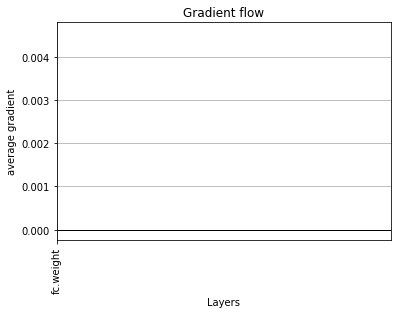

0.01756756756756757%1 1


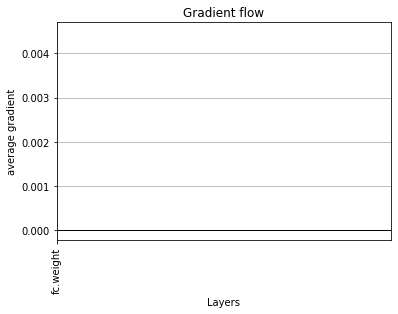

In [ ]:
model = train_model(resnet, criterion, optimizer, scheduler, epochs=10)

In [ ]:
torch.save(model.state_dict(), '/home/grzetan/PYTHON/Exercises-From-Hands-On-Machine-Learning/14-ComputerVision/with_freezed_layers')

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, scheduler, epochs=5)

In [ ]:
torch.save(model.state_dict(), '/home/grzetan/PYTHON/Exercises-From-Hands-On-Machine-Learning/14-ComputerVision/model')

In [ ]:
test_corr, test_loss = 0, 0.0

for input, label in test_loader:
    input = input.to(device)
    label = label.to(device)
    output = model(input)
    _, preds = torch.max(output, 1)
    loss = criterion(output, label)
    test_corr += torch.sum(preds == label)
    test_loss += loss.item() * input.size(0)
    
test_acc = test_corr / len(test_loader)
test_loss = test_loss / len(test_loader)

print(f"Test accuracy: {test_acc}, test loss - {test_loss}")